# Finloop PV segmentation with SAM

source (Huggingface): finloop/yolov8s-seg-solar-panels (aka Rzeszów model)

credits: https://blog.roboflow.com/how-to-use-yolov8-with-sam/ (Roboflow)

VI 25 with changes 15 X 25, 9 XI 25 and on

*MD*

note: a dual-use model (detection + instance segmentation)

requires OBB-versioned datasets

here: detect-YOLO

## libs

In [37]:
# %pip install numpy
# %pip install pandas
# %pip install ultralytics

In [38]:
import matplotlib.pyplot as plt
import cv2
from ultralytics import YOLO, SAM
import torch
from os import listdir
from os.path import isfile, join

In [39]:
dev = torch.device('cuda:0') if torch.cuda.is_available() else torch.device('cpu')
dev

device(type='cuda', index=0)

## defs

### data

In [40]:
pilot = 'pilotPV_panels.v1i.yolov8-obb/test/images/*.jpg'
rzeszow_test = 'rzeszowSolar panels seg.v2i.yolov8-obb/test/images/*.jpg'
rzeszow_train = 'rzeszowSolar panels seg.v2i.yolov8-obb/train/images/*.jpg'
rzeszow_valid = 'rzeszowSolar panels seg.v2i.yolov8-obb/valid/images/*.jpg'
synth_test = 'auto_pv_to_fine_tunning.v4i.yolov8-obb/test/images/*.jpg'
synth_train = 'auto_pv_to_fine_tunning.v4i.yolov8-obb/train/images/*.jpg'
synth_valid = 'auto_pv_to_fine_tunning.v4i.yolov8-obb/valid/images/*.jpg'

In [41]:
proste_1_zdj = "rzeszowSolar panels seg.v2i.yolov8-obb/test/images/022_jpg.rf.f76ab3a091f7c7931d2c26cc7375842b.jpg"
data_p = proste_1_zdj
pth = proste_1_zdj
nazwa = "proste_1_zdj"

### model

In [42]:
model_pt = "best.pt"

In [43]:
model = YOLO(model=model_pt, task="detect", verbose=True)

In [44]:
sam = SAM("sam_b.pt")

### segment analysis

In [45]:
def sum_pv_segments(pth, nazwa, model=model, disp_img=False, print_info=False):
    pv_area = 0
    image = cv2.cvtColor(cv2.imread(pth), cv2.COLOR_BGR2RGB)
    image = torch.tensor(image, device=dev)
    img_w, img_h, _ = image.shape
    img_w_cp, img_h_cp = img_w, img_h 
    yolo_results = model(pth, save=print_info, name=nazwa, stream=True, imgsz=(img_w, img_h))
    # YOLO requires dims of 32 multiply
    if img_h % 32 != 0 or img_w % 32 != 0:
        disp_img = False
    if img_h % 32 != 0:
        img_h = img_h // 32 + 1
        img_h *= 32
    if img_w % 32 != 0:
        img_w = img_w // 32 + 1
        img_w *= 32
    for i, res in enumerate(yolo_results):
        cnt = 0
        for j, box in enumerate(res.boxes):
            sam_results = sam.predict(source=pth, bboxes=box.xyxy)
            if res is not None and sam_results is not None:
                for jj, sam_res in enumerate(sam_results):
                    binary_mask = torch.where(sam_res.masks.data == True, 1, 0)
                    pv_area += binary_mask.sum().div(img_w_cp*img_h_cp) # percentage
                    if print_info:
                        print('\t', j, binary_mask.shape)
                    if disp_img:
                        binary_mask = binary_mask.data
                        print(binary_mask.shape)
                        bcg_white = torch.ones_like(image)*255
                        new_image = bcg_white * (1 - binary_mask[..., torch.newaxis]) + image * binary_mask[..., torch.newaxis]
                        plt.imshow(new_image.reshape((img_w, img_h, 3)).cpu())
                        plt.title(f"Mask {cnt} in {pth[pth.rfind('/'):]}")
                        plt.axis('off')
                        plt.show()
                        cnt += 1
            if print_info:
                print(pv_area.item())
        if disp_img:
            plt.imshow(image.cpu())
            plt.title(f"base img {pth[pth.rfind('/'):]}")
            plt.axis('off')
            plt.show()
    return pv_area

In [46]:
def sum_pv_segments_batch(imgs, nazwa="no_info_run", model=model, disp_img=False, print_info=False, display_coef=100):
    pv_area = 0
    if isinstance(imgs, str):
        if "*" in imgs:
            imgs = imgs.split("*")[0]
            imgs = [join(imgs, f) for f in listdir(imgs) if isfile(join(imgs, f)) and f.endswith('jpg')]
            for i, img in enumerate(imgs):
                do_disp = i % display_coef == 0
                pv_area += sum_pv_segments(img, nazwa, model, disp_img and do_disp, print_info)
            return pv_area
        return sum_pv_segments(imgs, nazwa, model, disp_img, print_info)
    else:
        for img in imgs:
            pv_area += sum_pv_segments(img, nazwa, model, disp_img, print_info)
    return pv_area

## segment

### numbers

jeden obraz

In [47]:
sumka = sum_pv_segments_batch(data_p, "proste_funk")
sumka


image 1/1 /home/marekd6/ZPB/modelling/modelling/rzeszowSolar panels seg.v2i.yolov8-obb/test/images/022_jpg.rf.f76ab3a091f7c7931d2c26cc7375842b.jpg: 640x640 4 solar-panels, 23.3ms

image 1/1 /home/marekd6/ZPB/modelling/modelling/rzeszowSolar panels seg.v2i.yolov8-obb/test/images/022_jpg.rf.f76ab3a091f7c7931d2c26cc7375842b.jpg: 1024x1024 1 0, 1268.9ms
Speed: 3.4ms preprocess, 1268.9ms inference, 1.7ms postprocess per image at shape (1, 3, 1024, 1024)

image 1/1 /home/marekd6/ZPB/modelling/modelling/rzeszowSolar panels seg.v2i.yolov8-obb/test/images/022_jpg.rf.f76ab3a091f7c7931d2c26cc7375842b.jpg: 1024x1024 1 0, 1278.5ms
Speed: 3.6ms preprocess, 1278.5ms inference, 0.9ms postprocess per image at shape (1, 3, 1024, 1024)

image 1/1 /home/marekd6/ZPB/modelling/modelling/rzeszowSolar panels seg.v2i.yolov8-obb/test/images/022_jpg.rf.f76ab3a091f7c7931d2c26cc7375842b.jpg: 1024x1024 1 0, 1267.0ms
Speed: 4.8ms preprocess, 1267.0ms inference, 0.9ms postprocess per image at shape (1, 3, 1024, 1024

tensor(0.0966, device='cuda:0')

In [48]:
sumka = sum_pv_segments_batch(data_p, "proste_funk", print_info=True)
sumka


image 1/1 /home/marekd6/ZPB/modelling/modelling/rzeszowSolar panels seg.v2i.yolov8-obb/test/images/022_jpg.rf.f76ab3a091f7c7931d2c26cc7375842b.jpg: 640x640 4 solar-panels, 19.9ms

image 1/1 /home/marekd6/ZPB/modelling/modelling/rzeszowSolar panels seg.v2i.yolov8-obb/test/images/022_jpg.rf.f76ab3a091f7c7931d2c26cc7375842b.jpg: 1024x1024 1 0, 1273.6ms
Speed: 4.2ms preprocess, 1273.6ms inference, 1.3ms postprocess per image at shape (1, 3, 1024, 1024)
	 0 torch.Size([1, 640, 640])
0.027150878682732582

image 1/1 /home/marekd6/ZPB/modelling/modelling/rzeszowSolar panels seg.v2i.yolov8-obb/test/images/022_jpg.rf.f76ab3a091f7c7931d2c26cc7375842b.jpg: 1024x1024 1 0, 1262.5ms
Speed: 3.5ms preprocess, 1262.5ms inference, 2.0ms postprocess per image at shape (1, 3, 1024, 1024)
	 1 torch.Size([1, 640, 640])
0.05205322057008743

image 1/1 /home/marekd6/ZPB/modelling/modelling/rzeszowSolar panels seg.v2i.yolov8-obb/test/images/022_jpg.rf.f76ab3a091f7c7931d2c26cc7375842b.jpg: 1024x1024 1 0, 1260.3m

tensor(0.0966, device='cuda:0')

podwójnie

In [49]:
sum_pv_segments_batch([data_p,data_p], "proste_funk_podwojnie")


image 1/1 /home/marekd6/ZPB/modelling/modelling/rzeszowSolar panels seg.v2i.yolov8-obb/test/images/022_jpg.rf.f76ab3a091f7c7931d2c26cc7375842b.jpg: 640x640 4 solar-panels, 19.9ms

image 1/1 /home/marekd6/ZPB/modelling/modelling/rzeszowSolar panels seg.v2i.yolov8-obb/test/images/022_jpg.rf.f76ab3a091f7c7931d2c26cc7375842b.jpg: 1024x1024 1 0, 1253.7ms
Speed: 4.1ms preprocess, 1253.7ms inference, 2.2ms postprocess per image at shape (1, 3, 1024, 1024)

image 1/1 /home/marekd6/ZPB/modelling/modelling/rzeszowSolar panels seg.v2i.yolov8-obb/test/images/022_jpg.rf.f76ab3a091f7c7931d2c26cc7375842b.jpg: 1024x1024 1 0, 1273.7ms
Speed: 4.3ms preprocess, 1273.7ms inference, 1.0ms postprocess per image at shape (1, 3, 1024, 1024)

image 1/1 /home/marekd6/ZPB/modelling/modelling/rzeszowSolar panels seg.v2i.yolov8-obb/test/images/022_jpg.rf.f76ab3a091f7c7931d2c26cc7375842b.jpg: 1024x1024 1 0, 1275.5ms
Speed: 3.8ms preprocess, 1275.5ms inference, 0.8ms postprocess per image at shape (1, 3, 1024, 1024

tensor(0.1931, device='cuda:0')

### imgs


image 1/1 /home/marekd6/ZPB/modelling/modelling/rzeszowSolar panels seg.v2i.yolov8-obb/test/images/022_jpg.rf.f76ab3a091f7c7931d2c26cc7375842b.jpg: 640x640 4 solar-panels, 19.9ms

image 1/1 /home/marekd6/ZPB/modelling/modelling/rzeszowSolar panels seg.v2i.yolov8-obb/test/images/022_jpg.rf.f76ab3a091f7c7931d2c26cc7375842b.jpg: 1024x1024 1 0, 1259.0ms
Speed: 4.3ms preprocess, 1259.0ms inference, 2.0ms postprocess per image at shape (1, 3, 1024, 1024)
torch.Size([1, 640, 640])


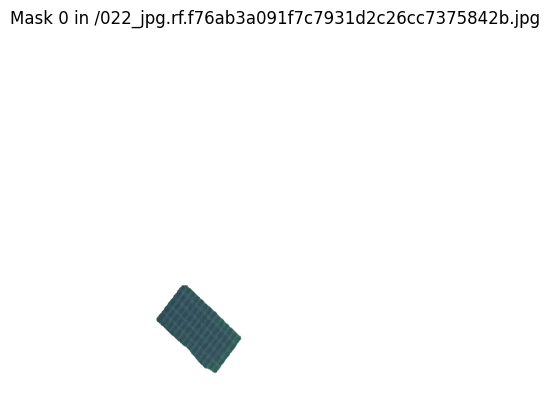


image 1/1 /home/marekd6/ZPB/modelling/modelling/rzeszowSolar panels seg.v2i.yolov8-obb/test/images/022_jpg.rf.f76ab3a091f7c7931d2c26cc7375842b.jpg: 1024x1024 1 0, 1284.7ms
Speed: 4.5ms preprocess, 1284.7ms inference, 0.7ms postprocess per image at shape (1, 3, 1024, 1024)
torch.Size([1, 640, 640])


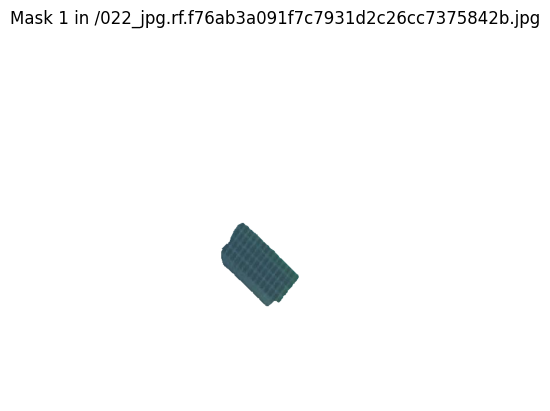


image 1/1 /home/marekd6/ZPB/modelling/modelling/rzeszowSolar panels seg.v2i.yolov8-obb/test/images/022_jpg.rf.f76ab3a091f7c7931d2c26cc7375842b.jpg: 1024x1024 1 0, 1234.8ms
Speed: 4.0ms preprocess, 1234.8ms inference, 1.3ms postprocess per image at shape (1, 3, 1024, 1024)
torch.Size([1, 640, 640])


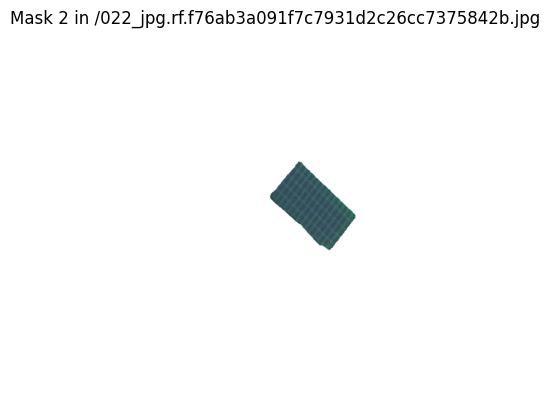


image 1/1 /home/marekd6/ZPB/modelling/modelling/rzeszowSolar panels seg.v2i.yolov8-obb/test/images/022_jpg.rf.f76ab3a091f7c7931d2c26cc7375842b.jpg: 1024x1024 1 0, 1277.5ms
Speed: 3.9ms preprocess, 1277.5ms inference, 0.7ms postprocess per image at shape (1, 3, 1024, 1024)
torch.Size([1, 640, 640])


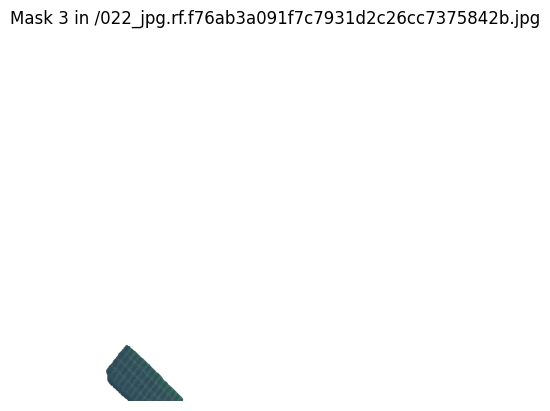

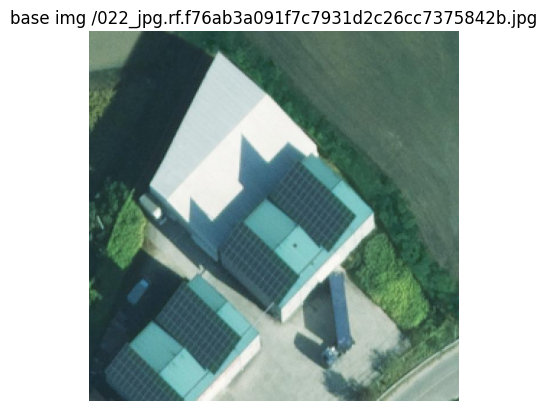

Speed: 1.5ms preprocess, 19.9ms inference, 2.5ms postprocess per image at shape (1, 3, 640, 640)


tensor(0.0966, device='cuda:0')

In [50]:
sum_pv_segments_batch(data_p, "proste_funk", disp_img=True)


image 1/1 /home/marekd6/ZPB/modelling/modelling/rzeszowSolar panels seg.v2i.yolov8-obb/test/images/022_jpg.rf.f76ab3a091f7c7931d2c26cc7375842b.jpg: 640x640 4 solar-panels, 19.8ms

image 1/1 /home/marekd6/ZPB/modelling/modelling/rzeszowSolar panels seg.v2i.yolov8-obb/test/images/022_jpg.rf.f76ab3a091f7c7931d2c26cc7375842b.jpg: 1024x1024 1 0, 1260.5ms
Speed: 7.8ms preprocess, 1260.5ms inference, 0.8ms postprocess per image at shape (1, 3, 1024, 1024)
torch.Size([1, 640, 640])


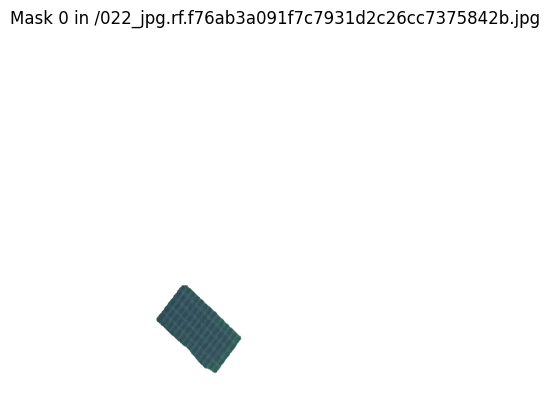


image 1/1 /home/marekd6/ZPB/modelling/modelling/rzeszowSolar panels seg.v2i.yolov8-obb/test/images/022_jpg.rf.f76ab3a091f7c7931d2c26cc7375842b.jpg: 1024x1024 1 0, 1260.6ms
Speed: 3.9ms preprocess, 1260.6ms inference, 1.5ms postprocess per image at shape (1, 3, 1024, 1024)
torch.Size([1, 640, 640])


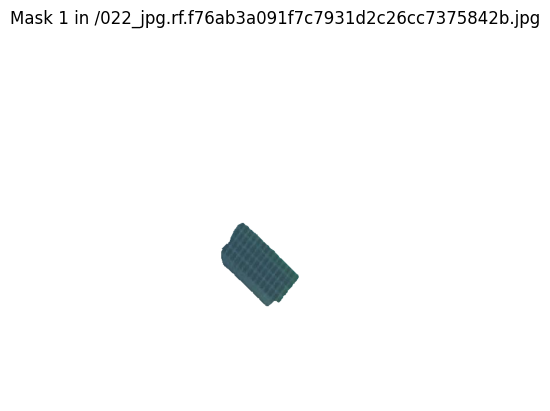


image 1/1 /home/marekd6/ZPB/modelling/modelling/rzeszowSolar panels seg.v2i.yolov8-obb/test/images/022_jpg.rf.f76ab3a091f7c7931d2c26cc7375842b.jpg: 1024x1024 1 0, 1245.2ms
Speed: 3.7ms preprocess, 1245.2ms inference, 1.2ms postprocess per image at shape (1, 3, 1024, 1024)
torch.Size([1, 640, 640])


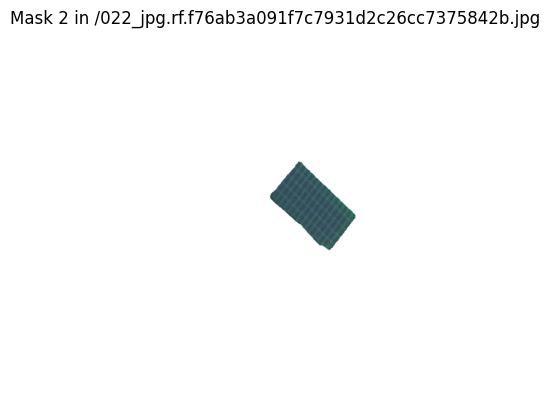


image 1/1 /home/marekd6/ZPB/modelling/modelling/rzeszowSolar panels seg.v2i.yolov8-obb/test/images/022_jpg.rf.f76ab3a091f7c7931d2c26cc7375842b.jpg: 1024x1024 1 0, 1272.0ms
Speed: 3.9ms preprocess, 1272.0ms inference, 2.1ms postprocess per image at shape (1, 3, 1024, 1024)
torch.Size([1, 640, 640])


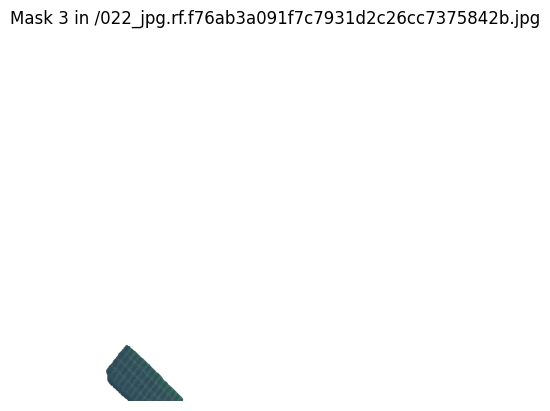

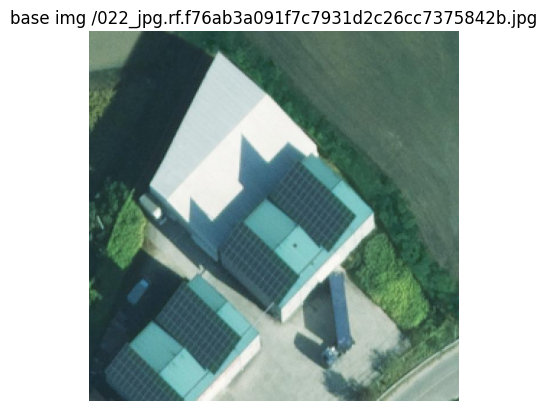

Speed: 2.8ms preprocess, 19.8ms inference, 3.3ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/marekd6/ZPB/modelling/modelling/rzeszowSolar panels seg.v2i.yolov8-obb/test/images/022_jpg.rf.f76ab3a091f7c7931d2c26cc7375842b.jpg: 640x640 4 solar-panels, 19.5ms

image 1/1 /home/marekd6/ZPB/modelling/modelling/rzeszowSolar panels seg.v2i.yolov8-obb/test/images/022_jpg.rf.f76ab3a091f7c7931d2c26cc7375842b.jpg: 1024x1024 1 0, 1271.2ms
Speed: 3.6ms preprocess, 1271.2ms inference, 1.7ms postprocess per image at shape (1, 3, 1024, 1024)
torch.Size([1, 640, 640])


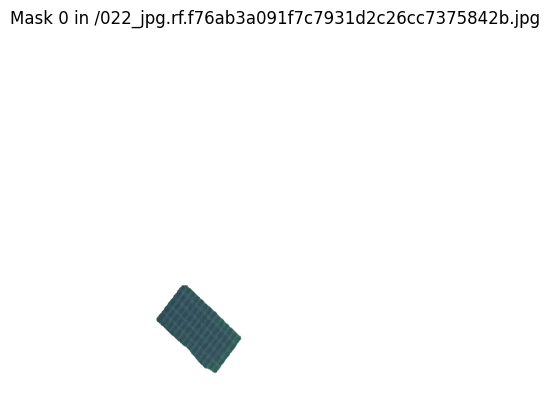


image 1/1 /home/marekd6/ZPB/modelling/modelling/rzeszowSolar panels seg.v2i.yolov8-obb/test/images/022_jpg.rf.f76ab3a091f7c7931d2c26cc7375842b.jpg: 1024x1024 1 0, 1271.0ms
Speed: 3.7ms preprocess, 1271.0ms inference, 0.8ms postprocess per image at shape (1, 3, 1024, 1024)
torch.Size([1, 640, 640])


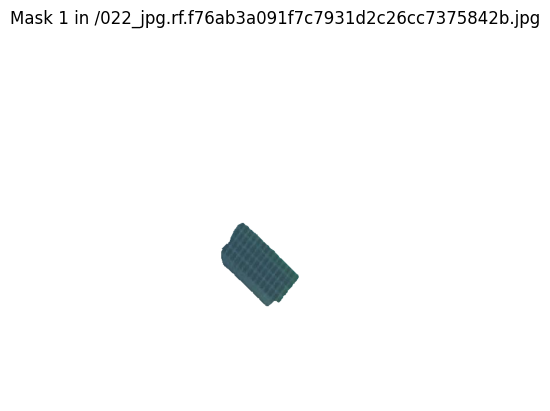


image 1/1 /home/marekd6/ZPB/modelling/modelling/rzeszowSolar panels seg.v2i.yolov8-obb/test/images/022_jpg.rf.f76ab3a091f7c7931d2c26cc7375842b.jpg: 1024x1024 1 0, 1268.7ms
Speed: 4.0ms preprocess, 1268.7ms inference, 0.7ms postprocess per image at shape (1, 3, 1024, 1024)
torch.Size([1, 640, 640])


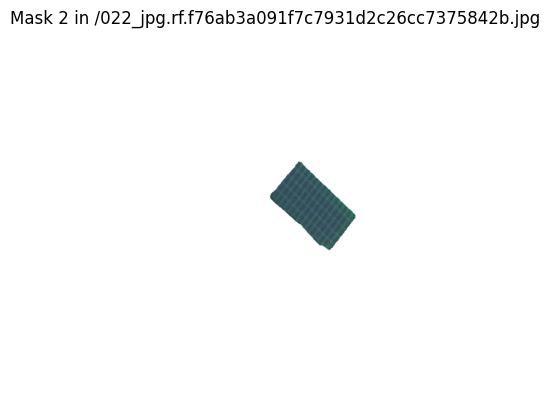


image 1/1 /home/marekd6/ZPB/modelling/modelling/rzeszowSolar panels seg.v2i.yolov8-obb/test/images/022_jpg.rf.f76ab3a091f7c7931d2c26cc7375842b.jpg: 1024x1024 1 0, 1246.8ms
Speed: 4.3ms preprocess, 1246.8ms inference, 0.7ms postprocess per image at shape (1, 3, 1024, 1024)
torch.Size([1, 640, 640])


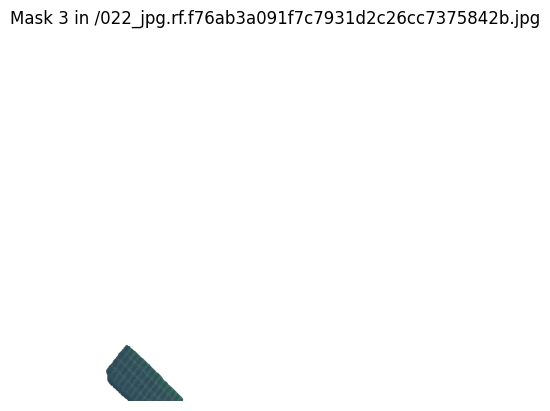

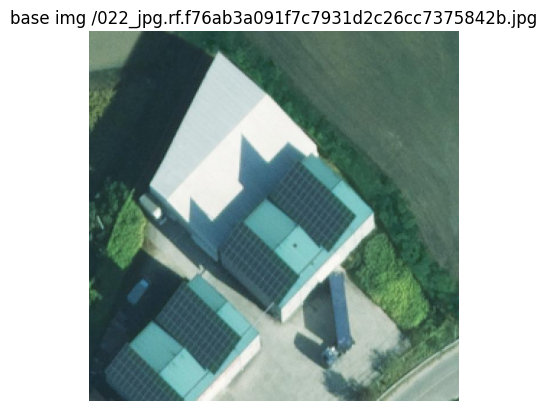

Speed: 1.2ms preprocess, 19.5ms inference, 4.7ms postprocess per image at shape (1, 3, 640, 640)


tensor(0.1931, device='cuda:0')

In [51]:
sum_pv_segments_batch([data_p,data_p], "proste_funk_podwojnie", disp_img=True)

## pilot


image 1/1 /home/marekd6/ZPB/modelling/modelling/pilotPV_panels.v1i.yolov8-obb/test/images/Zrzut-ekranu-387-_png.rf.8d9cf2f95f0bd6a3d3f4aab53d947b60.jpg: 640x640 5 solar-panels, 19.7ms

image 1/1 /home/marekd6/ZPB/modelling/modelling/pilotPV_panels.v1i.yolov8-obb/test/images/Zrzut-ekranu-387-_png.rf.8d9cf2f95f0bd6a3d3f4aab53d947b60.jpg: 1024x1024 1 0, 1276.4ms
Speed: 3.5ms preprocess, 1276.4ms inference, 2.0ms postprocess per image at shape (1, 3, 1024, 1024)
torch.Size([1, 640, 640])


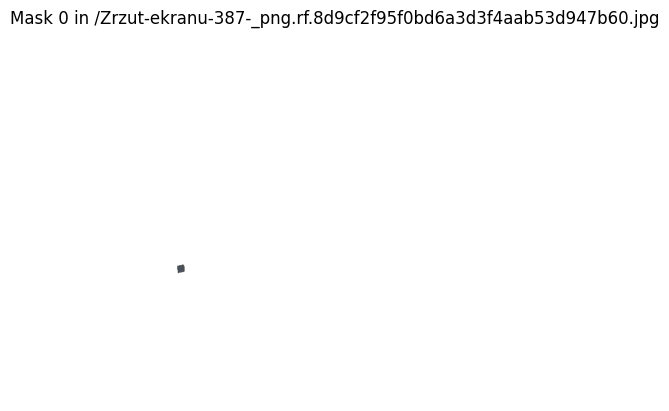


image 1/1 /home/marekd6/ZPB/modelling/modelling/pilotPV_panels.v1i.yolov8-obb/test/images/Zrzut-ekranu-387-_png.rf.8d9cf2f95f0bd6a3d3f4aab53d947b60.jpg: 1024x1024 1 0, 1283.5ms
Speed: 4.2ms preprocess, 1283.5ms inference, 0.8ms postprocess per image at shape (1, 3, 1024, 1024)
torch.Size([1, 640, 640])


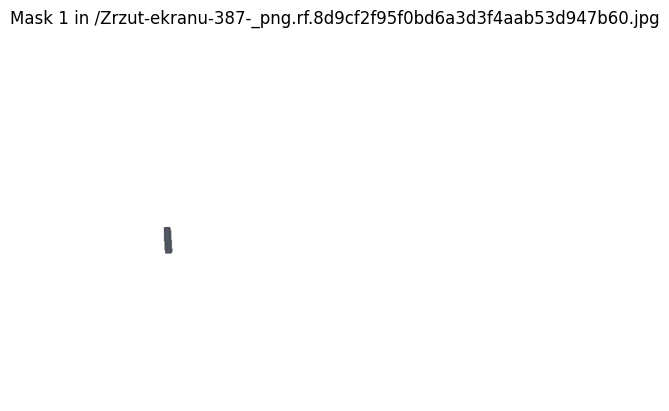


image 1/1 /home/marekd6/ZPB/modelling/modelling/pilotPV_panels.v1i.yolov8-obb/test/images/Zrzut-ekranu-387-_png.rf.8d9cf2f95f0bd6a3d3f4aab53d947b60.jpg: 1024x1024 1 0, 1280.9ms
Speed: 3.9ms preprocess, 1280.9ms inference, 1.9ms postprocess per image at shape (1, 3, 1024, 1024)
torch.Size([1, 640, 640])


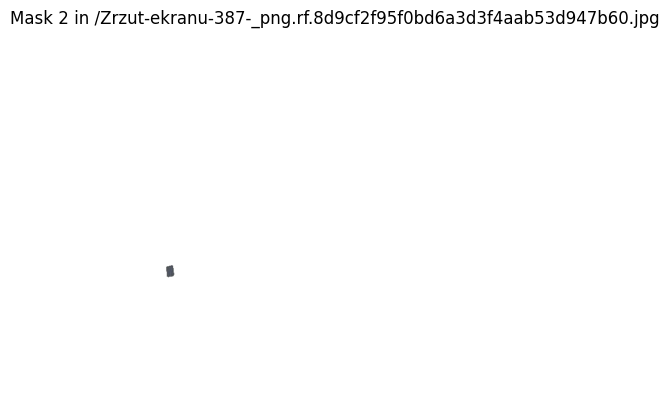


image 1/1 /home/marekd6/ZPB/modelling/modelling/pilotPV_panels.v1i.yolov8-obb/test/images/Zrzut-ekranu-387-_png.rf.8d9cf2f95f0bd6a3d3f4aab53d947b60.jpg: 1024x1024 1 0, 1266.9ms
Speed: 4.1ms preprocess, 1266.9ms inference, 0.8ms postprocess per image at shape (1, 3, 1024, 1024)
torch.Size([1, 640, 640])


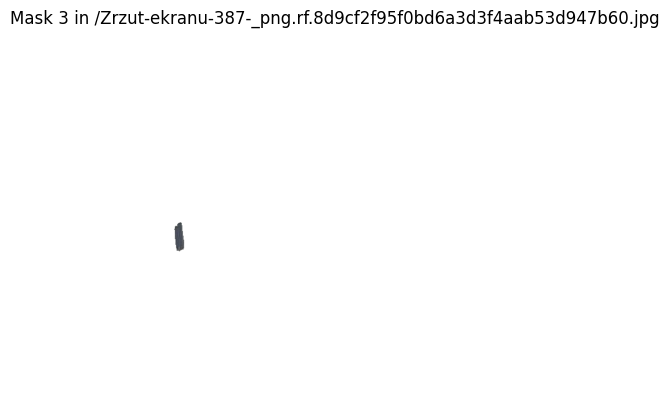


image 1/1 /home/marekd6/ZPB/modelling/modelling/pilotPV_panels.v1i.yolov8-obb/test/images/Zrzut-ekranu-387-_png.rf.8d9cf2f95f0bd6a3d3f4aab53d947b60.jpg: 1024x1024 1 0, 1257.8ms
Speed: 4.4ms preprocess, 1257.8ms inference, 1.6ms postprocess per image at shape (1, 3, 1024, 1024)
torch.Size([1, 640, 640])


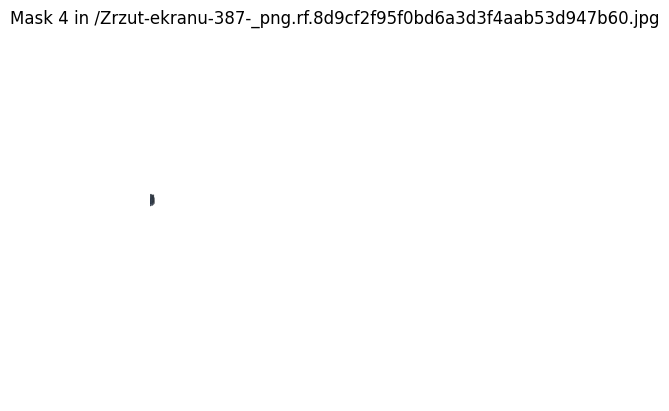

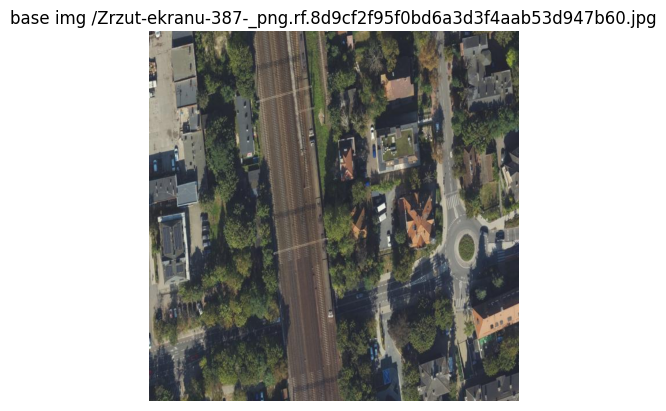

Speed: 1.8ms preprocess, 19.7ms inference, 4.8ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/marekd6/ZPB/modelling/modelling/pilotPV_panels.v1i.yolov8-obb/test/images/Zrzut-ekranu-391-_png.rf.389014ff4ad431e6038114a377054b0a.jpg: 640x640 2 solar-panels, 19.5ms

image 1/1 /home/marekd6/ZPB/modelling/modelling/pilotPV_panels.v1i.yolov8-obb/test/images/Zrzut-ekranu-391-_png.rf.389014ff4ad431e6038114a377054b0a.jpg: 1024x1024 1 0, 1242.2ms
Speed: 3.8ms preprocess, 1242.2ms inference, 0.8ms postprocess per image at shape (1, 3, 1024, 1024)

image 1/1 /home/marekd6/ZPB/modelling/modelling/pilotPV_panels.v1i.yolov8-obb/test/images/Zrzut-ekranu-391-_png.rf.389014ff4ad431e6038114a377054b0a.jpg: 1024x1024 1 0, 1246.9ms
Speed: 4.4ms preprocess, 1246.9ms inference, 2.0ms postprocess per image at shape (1, 3, 1024, 1024)
Speed: 1.6ms preprocess, 19.5ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/marekd6/ZPB/modelling/modelling/pilotPV_panels

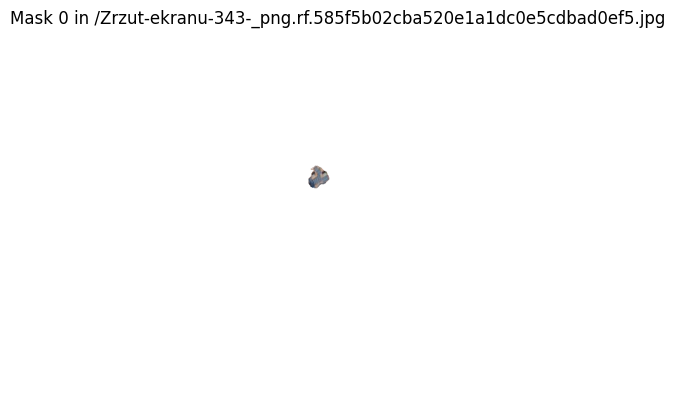


image 1/1 /home/marekd6/ZPB/modelling/modelling/pilotPV_panels.v1i.yolov8-obb/test/images/Zrzut-ekranu-343-_png.rf.585f5b02cba520e1a1dc0e5cdbad0ef5.jpg: 1024x1024 1 0, 1226.2ms
Speed: 4.3ms preprocess, 1226.2ms inference, 0.8ms postprocess per image at shape (1, 3, 1024, 1024)
torch.Size([1, 640, 640])


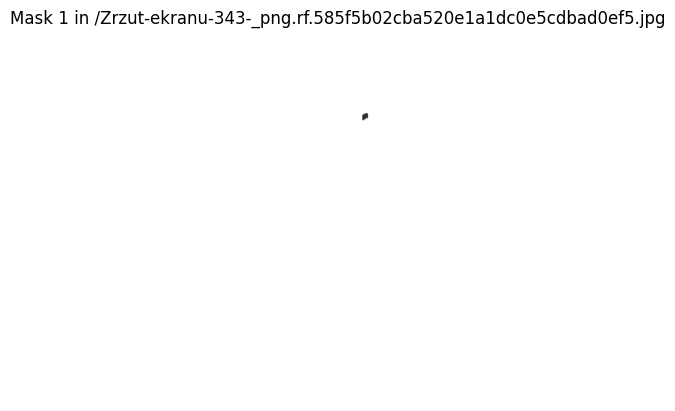

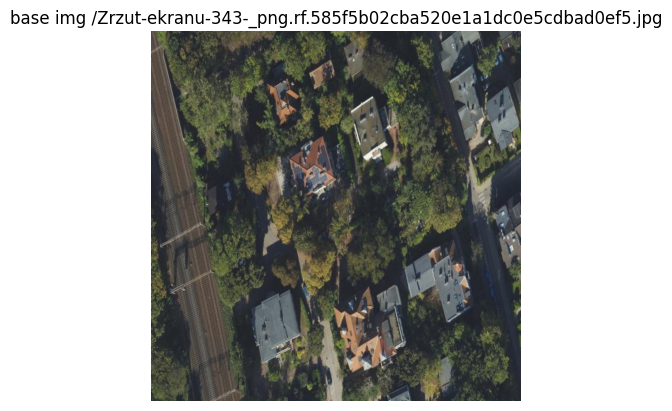

Speed: 1.4ms preprocess, 20.2ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/marekd6/ZPB/modelling/modelling/pilotPV_panels.v1i.yolov8-obb/test/images/Zrzut-ekranu-321-_png.rf.b2e9da026493829652fbb766c2f1efda.jpg: 640x640 9 solar-panels, 19.5ms

image 1/1 /home/marekd6/ZPB/modelling/modelling/pilotPV_panels.v1i.yolov8-obb/test/images/Zrzut-ekranu-321-_png.rf.b2e9da026493829652fbb766c2f1efda.jpg: 1024x1024 1 0, 1261.3ms
Speed: 3.9ms preprocess, 1261.3ms inference, 0.8ms postprocess per image at shape (1, 3, 1024, 1024)

image 1/1 /home/marekd6/ZPB/modelling/modelling/pilotPV_panels.v1i.yolov8-obb/test/images/Zrzut-ekranu-321-_png.rf.b2e9da026493829652fbb766c2f1efda.jpg: 1024x1024 1 0, 1228.0ms
Speed: 3.7ms preprocess, 1228.0ms inference, 0.8ms postprocess per image at shape (1, 3, 1024, 1024)

image 1/1 /home/marekd6/ZPB/modelling/modelling/pilotPV_panels.v1i.yolov8-obb/test/images/Zrzut-ekranu-321-_png.rf.b2e9da026493829652fbb766c2f1efda.jpg: 1024x1

tensor(0.3198, device='cuda:0')

In [52]:
sum_pv_segments_batch(pilot, "pilot_segment", disp_img=True, display_coef=33)

## synthetic

### train

In [55]:
sum_pv_segments_batch(synth_train, disp_img=True)

KeyboardInterrupt: 

### valid

In [56]:
sum_pv_segments_batch(synth_valid, disp_img=True, display_coef=10)

KeyboardInterrupt: 

### test

In [ ]:
sum_pv_segments_batch(synth_test, disp_img=True, display_coef=10)

## Rzeszów

### valid

In [ ]:
sum_pv_segments_batch(rzeszow_valid, disp_img=True, display_coef=333)

### test

In [ ]:
sum_pv_segments_batch(rzeszow_test, disp_img=True, display_coef=333)